_MS 9002: Data Mining Techniques_

### Python Lab session 3: Decision Trees 


---



In this lab we will investigate how to construct and deploy a decision tree model to predict whether a person earns more than $50k a month based on his  census data.  

_Learning objectives_

- To train and optimize a decision tree model. 
 

In [1]:
#@title Obtaining data {display-mode: "form"}
#@markdown Downloading the data from https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data and assigning column names to the dataset. 
import pandas as pd 
import requests
resp = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names')
# print(resp.text)
adult = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                       header=None)
adult.columns = ['age', 'workclass', 'fnlwgt','education', 'enducation-num',
                   'marital-status', 'occupation', 'relationship', 'race',
                   'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 
                   'native-country', 'target']
adult.shape

(32561, 15)

In [0]:
adult

0.8372485797635498


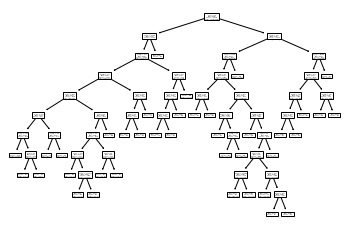

In [4]:
#@title Cross validating model {display-mode: "form"}
#@markdown Decision trees rely on several hyperparameters to control the training of the tree. One such hyperparameter is __minimum samples per leaf__ which is a rule guaranteeing a minimum number of samples at the leaves of the tree. A high number means that our decision tree is shallow, while a small number leads to a more complex tree.
min_samples_leaf = 500 #@param {type:"slider", min:500, max:1000, step:20}

## Using Sci Kit learn, we can easily set up cross validation loop to optimize
## on several hyper parameters. 

## Data cleansing. In order to use sci kit learn properly, we need to change
## the target labels into integer codes. 

## Further more, the feature set needs to be binarised. What this means is that
## we construct indicator variables for each unique value in a categorical 
## variable. This has the effect of enlarging our feature set. 
%matplotlib inline
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree

X = adult.iloc[:, :-1]
y = adult.loc[:, 'target']

X_train, X_test, y_train, y_test =\
  train_test_split(X, y, test_size=0.2)

# changing target categories to integer codes 
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)

# handle categorical features with One Hot Encoding scheme
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
categorical = [1,3,5,6,7,8,9,13]
column_transformer = ColumnTransformer(transformers=[('ohe', ohe, categorical)], 
                                       remainder='passthrough')
pipeline = make_pipeline(column_transformer, DecisionTreeClassifier())
pipeline.set_params(decisiontreeclassifier__min_samples_leaf=min_samples_leaf)

pipeline.fit(X_train, y_train) 
clf = pipeline.named_steps['decisiontreeclassifier'] 

plot_tree(clf);
print(pipeline.score(X_test, lb.transform(y_test)))

Fitting 5 folds for each of 26 candidates, totalling 130 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:   28.8s finished



decisiontreeclassifier__min_samples_leaf = 34
Best validation score: 0.8538

              precision    recall  f1-score   support

           0     0.8847    0.9317    0.9076      4960
           1     0.7372    0.6124    0.6690      1553

    accuracy                         0.8555      6513
   macro avg     0.8110    0.7720    0.7883      6513
weighted avg     0.8496    0.8555    0.8507      6513




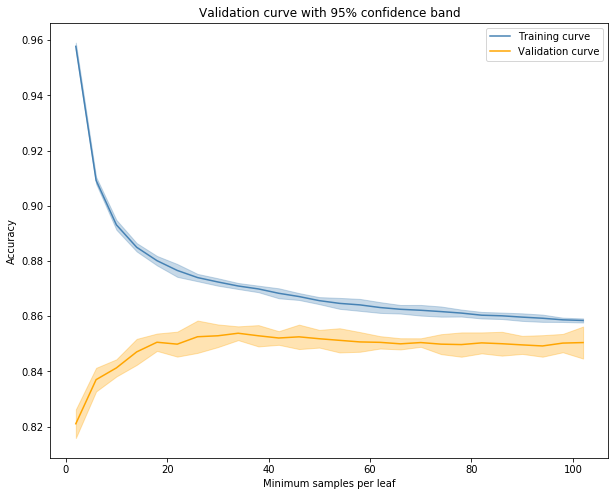

In [5]:
#@markdown Using code, we can automate the work of tuning models. The results are shown below. {display-mode: "form"}
import shutil 

WIDTH, _ = shutil.get_terminal_size() 

ticks = np.arange(2, 106, 4)

train_scores, test_scores =\
 validation_curve(pipeline, X_train, y_train, 
                  param_name='decisiontreeclassifier__min_samples_leaf', 
                  param_range=ticks, 
                  cv=5, n_jobs=-1, verbose=0)


def generate_confidence_bands(scores, alpha=.95): 
  from scipy.stats import bayes_mvs
  import numpy as np
  def mean_ci(arr): 
    m_cntr, _, __ = bayes_mvs(arr, alpha=alpha)
    mean, (lw, up ) = m_cntr
    return np.array([mean, lw, up])
  return np.apply_along_axis(mean_ci, axis=1, arr=scores)

# generate_confidence_bands(train_scores)
%matplotlib inline
import matplotlib.pyplot as plt

training_band = generate_confidence_bands(train_scores)
test_band = generate_confidence_bands(test_scores) 

fig, ax = plt.subplots(1,1,figsize=(10,8)) 
ax.fill_between(ticks, training_band[:, 1], training_band[:, 2],
                color='steelblue', alpha=0.3)
ax.fill_between(ticks, test_band[:, 1], test_band[:, 2], color='orange', alpha=0.3)
ax.plot(ticks, training_band[:, 0], color='steelblue', label='Training curve') 
ax.plot(ticks, test_band[:, 0], color='orange', label='Validation curve')

ax.legend(loc='best') 
ax.set_title('Validation curve with 95% confidence band')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Minimum samples per leaf');

# automated hyperparameter tuning 
from sklearn.model_selection import GridSearchCV 

grid = GridSearchCV(pipeline, param_grid={
    'decisiontreeclassifier__min_samples_leaf': ticks, 
    }, scoring='accuracy',
    n_jobs=-1, cv=5, verbose=1 )
grid.fit(X_train, y_train)

print('='*WIDTH + '\n')
print('{} = {}'.format(*list(grid.best_params_.items())[0]))
print('Best validation score: {:.4f}'.format(grid.best_score_))

# Using best model and doing a final evaluation 
from sklearn.metrics import classification_report
y_test = lb.transform(y_test)
y_pred = grid.predict(X_test)
print('='*WIDTH + '\n')
print(classification_report(y_test, y_pred, digits=4))
print('='*WIDTH + '\n')

__Discussion questions__

1. When you run the cell above, take special note of the way the graph for `mean_train_score` interacts with `mean_test_score`. Comment on this behaviour. 

2. What will be the effect of increasing the `min_samples_leaf` hyper parameter even further? 

3. What would be the optimal number of `min_samples_leaf`? 